# <span style="color:#F72585"><center>Tutorial Pyro</center></span>


## <span style="color:#4361EE">Introducción</span>


Se introducen los elementos esenciales del uso de Pyro. En este cuaderno usamos el ejemplo de 8 escuelas (eight schools) que utilizamos en el primer ejemplo de Pyro en este curso.

## <span style="color:#4361EE">Primitives</span>

Uno de los objetivos de Pyro es lograr que el código sea lo más elegante e intuitivo posible, las `primitives` buscan alcanzar ese objetivo, entre ellas encontramos:

- `pyro.sample`: Guarda en Python un generador de números aleatorios sobre la distribución o función que se le indique. El resultado de esta declaración es un tensor de Pytorch. 

Es posible ajustar los parámetros de la distribución a los datos que tenemos disponibles por medio de `obs`.



````{tab} Pyro
```python
x = pyro.sample('data',dist.Normal(0,1),obs=data)
```
````


-`pyro.param`: Permite registrar parámetros que se pueden aprender. Indicamos un nombre y un valor inicial que por lo general se usa solo la primera vez antes de iniciar un proceso de aprendizaje. El argumento `constraint` nos permite restringir nuestro parámetro a los valores que consideremos convenientes 


````{tab} Pyro
```python
y = pyro.param('y',torch.ones(5), constraint=positive)

```
````


-`pyro.plate`: Se usa para indicar que dos variables son condicionalmente independientes o que son 'intercambiables'. Podemos usar esta declaración de dos maneras distintas:

````{tab} Pyro
```python
with pyro.plate('data'),len(data),batch_size) as ids:
    pyro.sample('data',fun(x),obs=data[ids])
```
````


En este caso podemos generar múltiples muestras en paralelo a partir de múltiples datos. Es decir, nos permite tener grandes lotes de datos y operar en paralelo sobre cada uno de ellos. En ocasiones buscamos una estructura más dinámica y recorrer secuencialmente cada elemento del lote, para esto usamos:

````{tab} Pyro
```python
for i in pyro.plate('data'),len(data),batch_size) as ids:
    pyro.sample('data',fun(x),obs=data[ids])
```
````


## <span style="color:#4361EE">El modelo estadístico para este tutorial</span>


Supongamos que tenemos observaciones $[y_n |x_n], n=1,\ldots,N$, y asumamos el modelo Bayesiano. 

**Modelo con efectos aleatorios**

- Estima los hiperparámetros $\mu$ and $\tau$
- Predice los efectos aleatorios $\eta_i$


$$
\begin{align}
y_i &\sim \mathcal{N}(\theta_i,\sigma_i^2), \text{ known } \sigma_i^2\\
\theta_i & = \mu + \tau \times \eta_i \\
\eta_i &\sim \mathcal{N}(0, 1)\\
\mu &\propto 1\\
\tau &\propto 1
\end{align}
$$


### <span style="color:#4CC9F0">Los datos</span>


Los datos corresponden a la estimación (estandarizada) de un puntaje realizada en las ocho escuelas observadas. Este ejemplo es tratado en {cite}`gelman1995bayesian`


```{table}
|School |Estim. Treatment Effect | Estim. Stand. Error |
|---|---|---|
|A |28| 15|
|B |8 |10|
|C| -3| 16|
|D| 7| 11|
|E| -1 |9|
|F| 1| 11|
|G |18| 10|
|H| 12| 18|
```

In [28]:
# Importamos las librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import os
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS
import pyro.distributions.constraints as constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

In [11]:
# Los datos
J = 8 #Número de escuelas
y = torch.tensor([28, 8, -3, 7, -1, 1, 18, 12]).type(torch.Tensor) #Estimaciones de los efectos del tratamiento
sigma = torch.tensor([15, 10, 16, 11, 9, 11, 10, 18]).type(torch.Tensor) #Estimacion de la desviacion de los efectos del tratamiento
schools = np.array(['Choate', 'Deerfield', 'Phillips Andover', 'Phillips Exeter',
                    'Hotchkiss', 'Lawrenceville', "St. Paul's", 'Mt. Hermon'])

schools_dat = {'J': J,
               'y': y,
               'sigma': sigma}
schools_dat 

{'J': 8,
 'y': tensor([28.,  8., -3.,  7., -1.,  1., 18., 12.]),
 'sigma': tensor([15., 10., 16., 11.,  9., 11., 10., 18.])}

## <span style="color:#4361EE">Implementación del modelo estadístico en Pyro</span>

### <span style="color:#4CC9F0">Modelo</span>

In [20]:
def model(J,y,sigma):
    tau = torch.ones(J)
    mu = torch.ones(J)
    eta = pyro.sample('eta',dist.Normal(torch.zeros(J),torch.ones(J)))
    thetas = mu + tau*eta
    with pyro.plate("plate"):
        pyro.sample("y",dist.Normal(thetas,sigma),obs=y)   

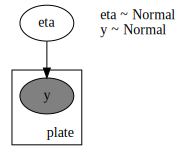

In [21]:
pyro.render_model(model,model_args=(J,y,sigma),render_distributions=True)

En este código los prámetros que serán muestreados son los $\eta_i$ (*eta*) que son los efectos aleatorios en el modelo. Las medias $\theta_i$ de las escuelas son calculados. Es decir, son funcionales de los parámetros.

### <span style="color:#4CC9F0">Guide</span>


En `guide` introduciremos una distribución variacional que contenga los parámetros variacionales. Con esta distribución buscamos llegar a la mejor aproximación de la posterior

```{admonition} Importante
:class: hint
Tenga en cuenta que si el modelo contiene una variable `pyro.sample('z_1',...)`, la guía necesita tener una variable `pyro.sample('z_1',...)`. No es necesario que ambas variables sigan la misma distribución o valor inicial, pero sí que tengan el mismo nombre y pertenezcan al mismo 'primitive' 
```


In [22]:
def guide_model(J,y,sigma):
    tau__0 = pyro.param('tau_0',torch.ones(J), constraint=constraints.positive)
    mu_0 = pyro.param('mu_0',torch.ones(J))
    pyro.sample('eta',dist.Normal(torch.zeros(J),torch.ones(J)))
    

## <span style="color:#4361EE">Compilación del modelo</span>


`NUTS` es una herramienta para hacer inferencia bayesiana usando 'No-U-Turn Sampler' {cite}`hoffman2014nuts`. `MCMC` hace referencia a Markov chain Monte Carlo. En este caso lo usaremos para acceder a los algoritmos de inferencia MCMC disponibles en Pyro.

In [23]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=300)
mcmc.run(J,y,sigma)

Sample: 100%|██████████| 800/800 [00:24, 32.73it/s, step size=7.08e-01, acc. prob=0.903]


In [24]:
 mcmc.summary(prob=0.5)



                mean       std    median     25.0%     75.0%     n_eff     r_hat
    eta[0]      0.08      1.01      0.08     -0.48      0.72    748.38      1.00
    eta[1]      0.06      0.93      0.03     -0.46      0.74    809.28      1.00
    eta[2]     -0.03      1.03     -0.01     -0.60      0.78    819.37      1.00
    eta[3]      0.06      0.99     -0.00     -0.81      0.53    990.00      1.00
    eta[4]     -0.05      1.06     -0.03     -0.82      0.43   1031.35      1.00
    eta[5]      0.01      0.96      0.03     -0.89      0.45    728.41      1.00
    eta[6]      0.17      0.93      0.18     -0.35      0.75    797.50      1.00
    eta[7]      0.02      0.89     -0.01     -0.62      0.43    837.12      1.00

Number of divergences: 0


Una vez el modelo es compilado, se pueden generar muestras cuando se desee.

In [16]:
samples=mcmc.get_samples()
samples

{'eta': tensor([[-1.0944,  1.4402,  0.5232,  ..., -0.3845,  0.2448, -0.0706],
         [ 1.1940, -2.1953, -0.1871,  ...,  0.1124,  0.6073,  0.0705],
         [ 0.9881, -0.2422, -1.3316,  ...,  0.1053,  0.0171, -1.0768],
         ...,
         [-0.0374,  0.6343, -0.2479,  ..., -1.1761,  0.9502,  1.5435],
         [-1.8467, -1.8912,  0.7523,  ..., -1.0602,  1.0763, -0.3157],
         [ 1.6580,  2.0001, -0.8659,  ...,  1.2931, -0.9664,  0.6077]])}

## <span style="color:#4361EE">Optimización del modelo</span>


Para la optimización del modelo usaremos Adam (Adaptative moment estimation)

In [29]:
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
#Fijamos el algoritmo de inferencia con base el el modelo optimizado
svi = SVI(model, guide_model, optimizer, loss=Trace_ELBO())